In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime
import dask.dataframe as dd
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import train_test_split

C:\Users\Yingting-PC\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
os.chdir('E:\personal project\Lending Club')

In [ ]:
#dff = dd.read_csv('LoanStats_2015.csv',dtype='str')
#dff.loan_status.value_counts().compute()
#df=dff[dff.loan_status.isin(['Fully Paid','Charged Off','Late (31-120 days),','Default','In Grace Period','Late (16-30 days)'])].compute()
#df.reset_index(inplace=True,drop=True)
#df.to_csv('LoanStats_2015_nocurrent.csv',index=False)

In [3]:
df = pd.read_csv('LoanStats_2015_nocurrent.csv',dtype='str',encoding='latin-1')

In [4]:
df.shape

(249633, 145)

In [5]:
delete_col=df.isnull().sum()[df.isnull().sum()/len(df)>0.5].index.tolist()

In [6]:
df.drop(delete_col,inplace=True,axis=1)

In [7]:
# variables will not be used for applications model
not_used_cols=['funded_amnt','funded_amnt_inv','issue_d','pymnt_plan','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',
'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','last_pymnt_amnt',
'collections_12_mths_ex_med','policy_code','delinq_amnt','hardship_flag','debt_settlement_flag','last_credit_pull_d']

In [8]:
df.drop(not_used_cols,inplace=True,axis=1)

In [9]:
df.shape

(249633, 67)

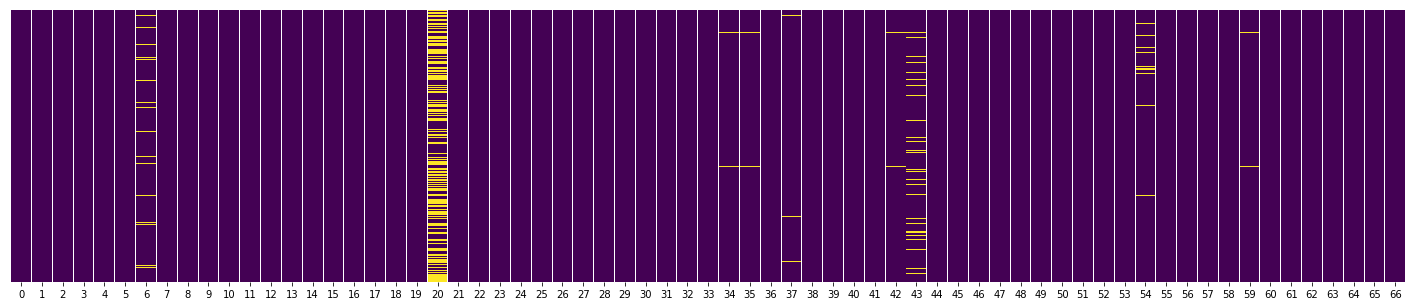

In [10]:
plt.figure(figsize=(25,5)) 
sns.set_context(font_scale=10)   
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis',xticklabels=list(range(len(df.columns))))

In [11]:
df.isnull().sum()[df.isnull().sum()>0]

emp_title                  13709
title                         65
dti                            2
mths_since_last_delinq    120457
revol_util                   110
bc_open_to_buy              2531
bc_util                     2707
mo_sin_old_il_acct          6782
mths_since_recent_bc        2422
mths_since_recent_inq      22490
num_rev_accts                  1
num_tl_120dpd_2m           11441
percent_bc_gt_75            2699
dtype: int64

In [12]:
# remove units
df.int_rate=df.int_rate.str[:-1]
df.revol_util=df.revol_util.str[:-1]
df.term=df.term.str[:3]

df.emp_length[(df.emp_length!='1 year')&(df.emp_length!='< 1 year')&(df.emp_length!='10+ years')]=df.emp_length[(df.emp_length!='1 year')&(df.emp_length!='< 1 year')&(df.emp_length!='10+ years')].str[:-6]
df.emp_length[df.emp_length=='< 1 year']=df.emp_length[df.emp_length=='< 1 year'].str[:-5]
df.emp_length[df.emp_length=='1 year']=df.emp_length[df.emp_length=='1 year'].str[:-5]
df.emp_length[df.emp_length=='10+ years']=df.emp_length[df.emp_length=='10+ years'].str[:-7]
# '<1 year'-->0, '10+ years'-->10
df.emp_length[df.emp_length=='< 1']=0
df.emp_length[df.emp_length=='']=np.nan

# keep first 3 digit of zipcode
df.zip_code=df.zip_code.str[:-2]

In [13]:
# good loans(0) and bad loan(1) 
df.loan_status.value_counts()

Fully Paid           183593
Charged Off           62042
In Grace Period        2943
Late (16-30 days)      1033
Default                  22
Name: loan_status, dtype: int64

In [14]:
# good loans(0) and bad loan(1) 
df['label']='0'
df.loc[df.loan_status.isin(['Charged Off','Late (16-30 days)','Default']),'label']='1'

In [17]:
df.label.value_counts()

0    186536
1     63097
Name: label, dtype: int64

In [18]:
# transform date into duration (in years)
earl_d=df.earliest_cr_line
earl_y=[datetime.strptime(x,'%m/%d/%Y').year for x in earl_d]
dur_y=np.repeat(2015,len(earl_y))-earl_y

In [19]:
df['dur_y']=dur_y

In [20]:
df.fillna(-999,inplace=True)

In [21]:
l_int=['loan_amnt','term','emp_length','zip_code','delinq_2yrs','inq_last_6mths',
      'mths_since_last_delinq','open_acc','pub_rec','revol_bal','total_acc','acc_now_delinq','tot_coll_amt',
      'tot_cur_bal','total_rev_hi_lim','acc_open_past_24mths','avg_cur_bal', 'bc_open_to_buy','chargeoff_within_12_mths', 
       'mo_sin_old_il_acct','mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl','mort_acc', 
       'mths_since_recent_bc', 'mths_since_recent_inq','num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl','num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 
       'num_tl_120dpd_2m','num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m','pub_rec_bankruptcies','tax_liens', 
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit','total_il_high_credit_limit','dur_y']
l_float=['int_rate','annual_inc','installment','dti','revol_util','bc_util','pct_tl_nvr_dlq', 'percent_bc_gt_75']
l_object=['grade', 'sub_grade', 'emp_title', 'home_ownership','verification_status', 'loan_status', 'purpose', 'title', 
          'addr_state','earliest_cr_line', 'initial_list_status', 'application_type','disbursement_method', 'label']

In [22]:
for i in l_int:
    df[i]=df[i].astype(int)
for i in l_float:
    df[i]=df[i].astype(float)
for i in l_object:
    df[i]=df[i].astype(object)

In [23]:
len(l_float)+len(l_int)+len(l_object)

69

In [23]:
dff=df.drop(['loan_status','earliest_cr_line'],axis=1)

In [ ]:
#dff.to_csv('2015clean.csv',index=False)

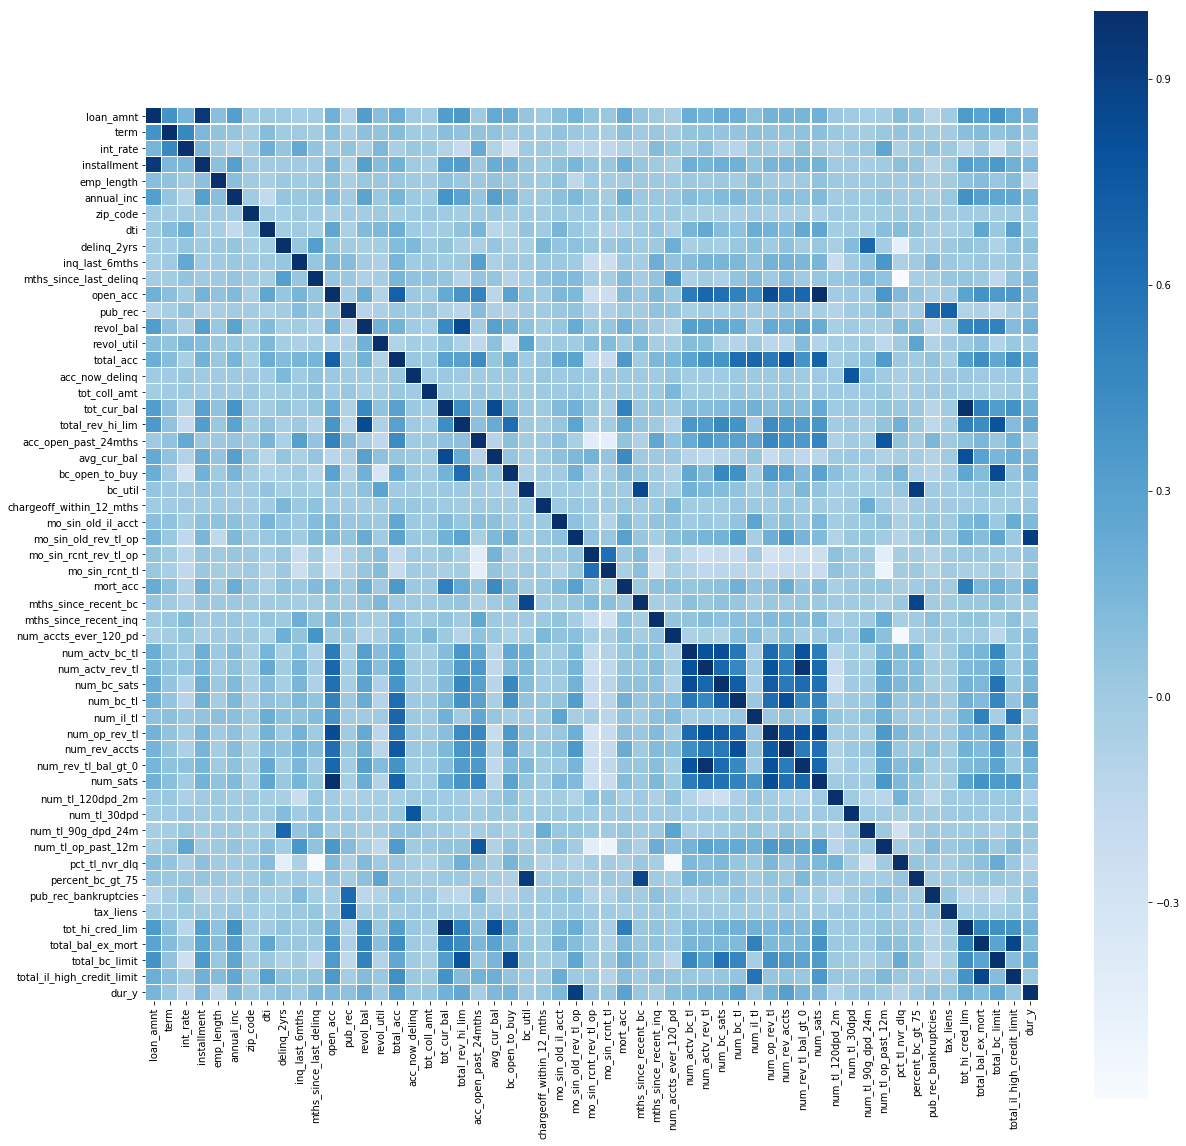

In [24]:
corr=dff.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr,cmap=plt.cm.Blues,square=True,annot_kws={'size':8},linewidths=0.1)

In [ ]:
for i in corr.columns:
    high_cor=corr[i][1:][(corr[i].values[1:]>0.6)&(corr[i].values[1:]<1)]
    if high_cor.shape[0]>0:
        print(i)
        print(high_cor.sort_values(ascending=False))
        print('------------------')

C:\Users\Yingting-PC\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


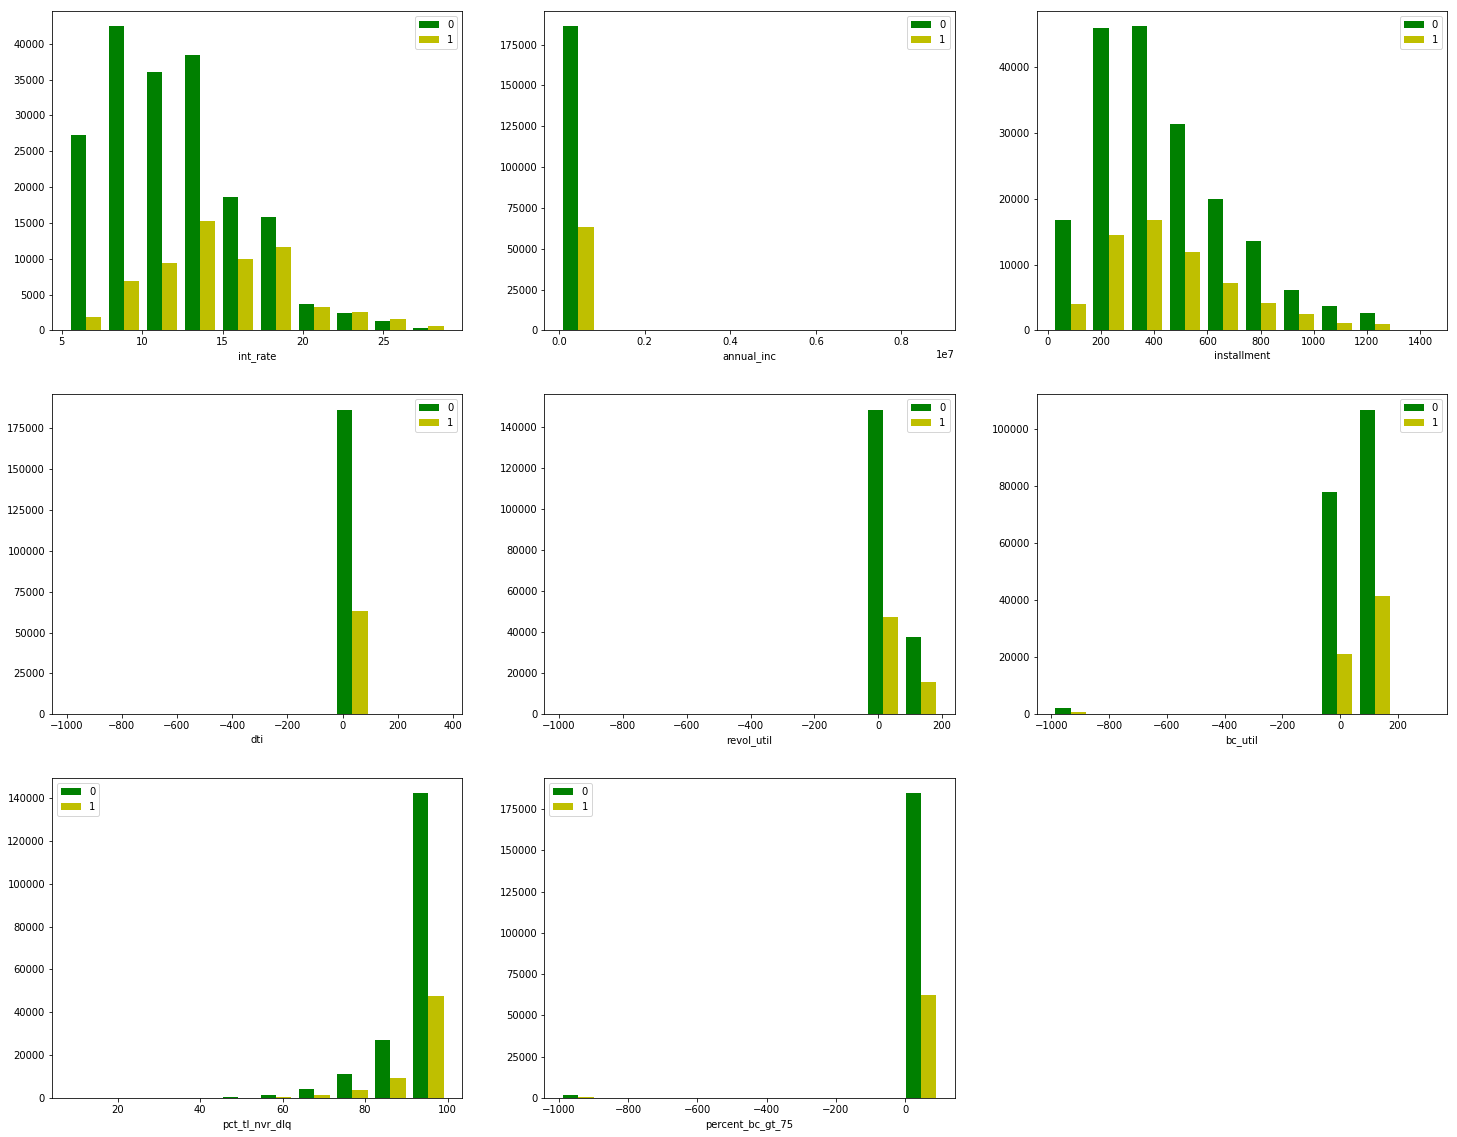

In [25]:
fig = plt.figure(figsize=(25,20))
for i in range(len(l_float)):
    ax=fig.add_subplot(3, 3, i+1)
    x1=dff[dff['label']=='0'][l_float[i]]
    x2=dff[dff['label']=='1'][l_float[i]]
    ax.hist([x1, x2], color=['g','y'], label=['0','1'])
    ax.set_xlabel(l_float[i])
    ax.legend()

In [ ]:
dff.head()

In [37]:
ll_object=['grade', 'sub_grade', 'home_ownership','verification_status', 'purpose', 'title', 
          'addr_state', 'initial_list_status', 'application_type','disbursement_method']

In [ ]:
dff.emp_title.value_counts()
#'emp_title'

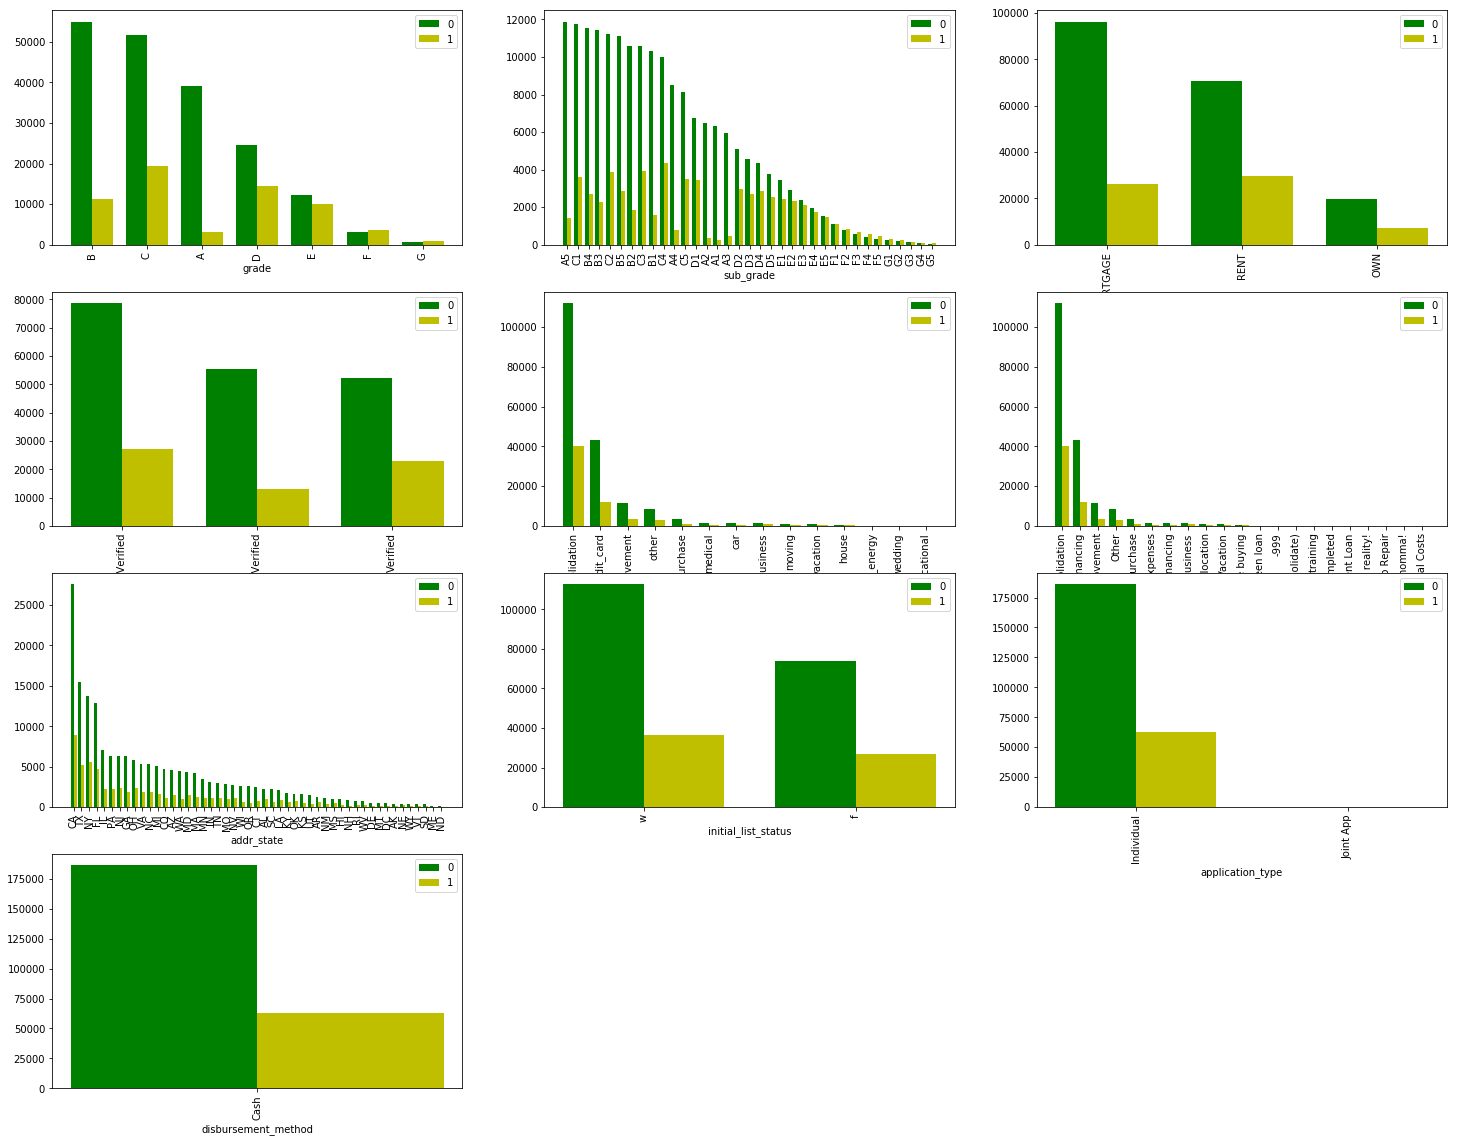

In [39]:
fig = plt.figure(figsize=(25,25))
for i in range(len(ll_object)):
    ax=fig.add_subplot(5, 3, i+1,)
    fea_ct=pd.crosstab(dff[ll_object[i]],dff.label).sort_values('0',ascending=False)
    width=0.38
    ind=np.arange(len(fea_ct.index))
    ax.bar(ind,fea_ct.iloc[:,0],width,color=['g'], label='0')
    ax.bar(ind+width,fea_ct.iloc[:,1],width,color=['y'], label='1')
    ax.set_xlabel(ll_object[i])
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(fea_ct.index.tolist())
    ax.legend()
    plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')

In [28]:
X=np.array(dff[l_float+l_int+ll_object])
Y=dff['label'].astype(int)

In [31]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=33)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(199706, 66)
(49927, 66)
(199706,)
(49927,)


In [34]:
x_train

array([[15.61, 37400.0, 396.64, ..., 'w', 'Individual', 'Cash'],
       [8.19, 85000.0, 125.7, ..., 'w', 'Individual', 'Cash'],
       [19.99, 250000.0, 1243.89, ..., 'f', 'Individual', 'Cash'],
       ...,
       [23.99, 45355.0, 652.19, ..., 'w', 'Individual', 'Cash'],
       [18.84, 106000.0, 292.61, ..., 'w', 'Individual', 'Cash'],
       [13.33, 42000.0, 355.46, ..., 'f', 'Individual', 'Cash']],
      dtype=object)

In [33]:
dt=tree.DecisionTreeClassifier()
dt.fit(x_train,y_train)
dt.predict(x_test)

ValueError: could not convert string to float: 'Cash'